# Data Preparation


In [19]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [20]:
#Load dataset
df = pd.read_csv('train (2).csv')

# 2. Cleaning and Feature Selection
# Drop irrelevant columns
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# Fill missing values (Age with median, Embarked with the most common value)
df['Age'] = df['Age'].fillna(df['Age'].median())
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [21]:
# Encode Categorical Variables (Sex and Embarked)
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex']) # Female=0, Male=1
df['Embarked'] = le.fit_transform(df['Embarked'])

In [22]:
# 3. Define Features and Target
X = df.drop('Survived', axis=1)
y = df['Survived']

# 4. Split and Scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
#scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Training and Comparison

In [24]:
import lightgbm as lgb

# Initializing the 4 models
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1)
}

results = {}
preds_dict = {}

In [25]:
# Training each model to get each metric for comparison
print(f"{'Model':<20} | {'Accuracy':<10} | {'F1-Score':<10}")
print("-" * 45)

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    preds_dict[name] = y_pred

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results[name] = {
        "Accuracy": acc,
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1
    }
    print(f"{name:<20} | {acc:<10.4f} | {f1:<10.4f}")


Model                | Accuracy   | F1-Score  
---------------------------------------------
Logistic Regression  | 0.8045     | 0.7552    
SVM                  | 0.8156     | 0.7626    
Random Forest        | 0.8212     | 0.7746    
LightGBM             | 0.8212     | 0.7838    


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# Visualization (Confusion Matrices)

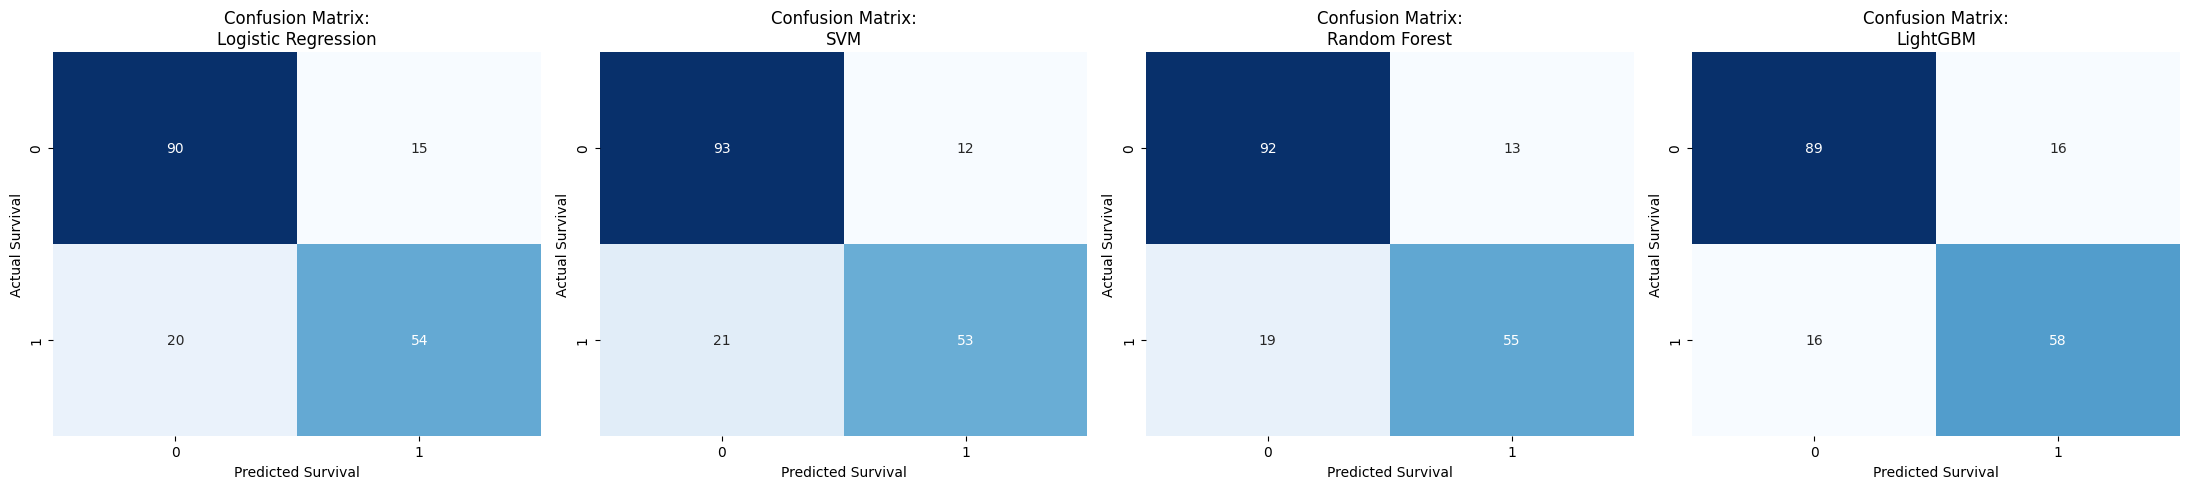

In [26]:
fig, axes = plt.subplots(1, 4, figsize=(22, 5))

for i, (name, y_pred) in enumerate(preds_dict.items()):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f'Confusion Matrix:\n{name}')
    axes[i].set_xlabel('Predicted Survival')
    axes[i].set_ylabel('Actual Survival')

plt.tight_layout()
plt.show()

In [27]:
import joblib

joblib.dump(model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [28]:
import streamlit as st
import pandas as pd
import joblib
import numpy as np

# 1. Load the saved model and scaler
@st.cache_resource
def load_models():
    model = joblib.load('model.pkl')
    scaler = joblib.load('scaler.pkl')
    return model, scaler

model, scaler = load_models()

# 2. Web App UI
st.title("🚢 Titanic Survival Predictor")
st.markdown("Enter passenger details below to see if they would have survived the disaster.")

st.sidebar.header("Passenger Details")

def user_input_features():
    pclass = st.sidebar.selectbox("Ticket Class (Pclass)", [1, 2, 3], help="1 = First, 2 = Second, 3 = Third")
    sex = st.sidebar.selectbox("Sex", ["male", "female"])
    age = st.sidebar.slider("Age", 0, 80, 30)
    sibsp = st.sidebar.number_input("Siblings/Spouses Aboard", 0, 10, 0)
    parch = st.sidebar.number_input("Parents/Children Aboard", 0, 10, 0)
    fare = st.sidebar.number_input("Fare Paid", 0.0, 500.0, 32.0)
    embarked = st.sidebar.selectbox("Port of Embarkation", ["S", "C", "Q"])

    # Convert categorical to numerical (matching our training)
    sex_val = 1 if sex == "male" else 0
    emb_map = {"S": 2, "C": 0, "Q": 1}
    embarked_val = emb_map[embarked]

    data = {
        'Pclass': pclass,
        'Sex': sex_val,
        'Age': age,
        'SibSp': sibsp,
        'Parch': parch,
        'Fare': fare,
        'Embarked': embarked_val
    }
    return pd.DataFrame(data, index=[0])

input_df = user_input_features()

# 3. Prediction Logic
st.subheader("Passenger Profile")
st.write(input_df)

if st.button("Predict Survival"):
    # Scale input
    input_scaled = scaler.transform(input_df)

    # Predict
    prediction = model.predict(input_scaled)
    prediction_proba = model.predict_proba(input_scaled)

    st.subheader("Result")
    if prediction[0] == 1:
        st.success(f"Outcome: **Survived** (Probability: {prediction_proba[0][1]:.2%})")
        st.balloons()
    else:
        st.error(f"Outcome: **Did Not Survive** (Probability: {prediction_proba[0][0]:.2%})")

2026-01-22 17:35:32.910 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-22 17:35:32.913 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-22 17:35:32.915 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-22 17:35:32.916 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-22 17:35:32.917 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-22 17:35:32.918 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-22 17:35:32.919 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-01-22 17:35:32.920 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [ ]:
!pip install streamlit -q
!npm install -g localtunnel -q
# Run streamlit in background


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 44.2 MB/s eta 0:00:00
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦
added 22 packages in 3s
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦⠙⠹⠸⠼⠴⠦⠧⠇Usage: streamlit run [OPTIONS] [TARGET] [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py
⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼your url is: https://swift-suns-bathe.loca.lt
^C


In [ ]:
import pickle

# Assuming 'rf' was your best model
best_model = models["Random Forest"]

with open('titanic_survival_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)